# Measurement Framework Library MFLib
Add measurement capabilities while creating new slice.

## This Notebook Version for Testing
Just to make sure we are all on the same version for debugging.
1.03


## Install MFLIB

git clone https://github.com/fabric-testbed/fabrictestbed-extensions.git  
cd fabrictestbed-extensions  
git checkout mflib  
pip install --user .  



Later you can restore the main branch using:
git checkout main
pip install --user .

## General Imports

In [ ]:
import os
import json
import traceback

## Import MFLib

In [ ]:
# If you installed the fabrictestbed_extensions you can use:
from fabrictestbed_extensions.mflib.mflib import mflib
# If you are using a local copy of the mflib.py file use:
#from mflib import mflib

In [ ]:
# Change repo for testing
mflib.mf_repo_branch = "dev"

## Setup Experiment Slice

### Import fablib & set slice information

In [ ]:
%%time
from fabrictestbed_extensions.fablib.fablib import fablib

slice_name = "MyMonitoredSlice"
[site] = fablib.get_random_sites(avoid=["FIU", "NCSA", "GPN", "CLEM", "UCSD"])
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'
network_name='net1'
node1_nic_name = 'nic1'
node2_nic_name = 'nic2'
node3_nic_name = 'nic3'
image = 'default_ubuntu_20'
image_type = 'qcow2'
cores = 2
ram = 8
disk = 10
print(f"Using slice {slice_name} at site {site}")

### Create Experiment Topology

In [ ]:
try:
    print("Setting up slice...")
    #Create Slice
    slice = fablib.new_slice(name=slice_name)

    # Node1
    node1 = slice.add_node(name=node1_name, site=site)
    node1.set_capacities(cores=cores, ram=ram, disk=disk)
    node1.set_image(image)
    iface1 = node1.add_component(model='NIC_Basic', name=node1_nic_name).get_interfaces()[0]
   
    # Node2
    node2 = slice.add_node(name=node2_name, site=site)
    node2.set_capacities(cores=cores, ram=ram, disk=disk)
    node2.set_image(image)
    iface2 = node2.add_component(model='NIC_Basic', name=node2_nic_name).get_interfaces()[0]
    
    # Node3
    node3 = slice.add_node(name=node3_name, site=site)
    node3.set_capacities(cores=cores, ram=ram, disk=disk)
    node3.set_image(image)
    iface3 = node3.add_component(model='NIC_Basic', name=node3_nic_name).get_interfaces()[0]
        
    
    # Network
    net1 = slice.add_l2network(name=network_name, interfaces=[iface1, iface2, iface3])
    
    print("Slice setup done.")
    
except Exception as e:
    print(f"Slice Fail: {e}")
    traceback.print_exc()

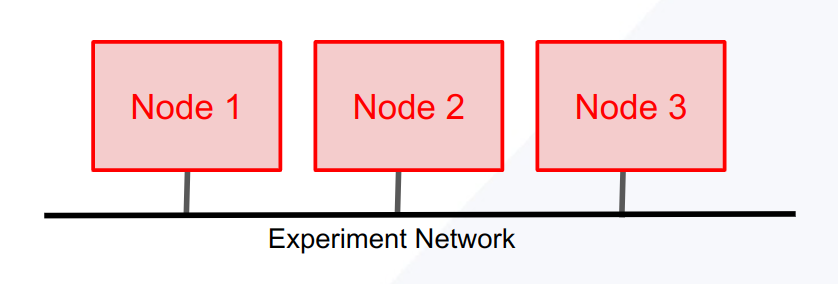

### Add measurement node to slice topology.

In [ ]:
# Add measurement node to topology using static method.
mflib.addMeasNode(slice)
print("Done")

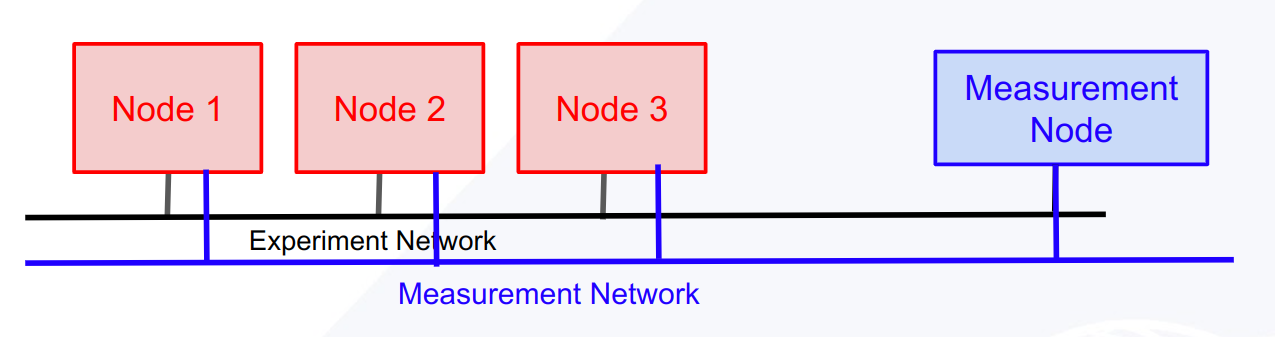

### Submit the Slice

In [ ]:
%%time
try:
    # Submit Slice Request
    print("Submitting the new slice...")
    #slice.submit()
    slice.submit(wait_timeout=1000, wait_interval=60)
    print("Slice creation done.")

except Exception as e:
    print(f"Slice Fail: {e}")
    traceback.print_exc()

In [ ]:

#slice.wait_jupyter(timeout=1000, interval=60)

 ## Create the MFLib object with the new created slice.
Create a new MFLib object by passing the name of your slice as slice_name.  
When you first create a MFLib object, MFLib will run an initialization process to setup the needed accounts and software on the Measurement Node and on the experiement's nodes. The first time the initialization is run will take several minutes. Subsequent initializations will just check that the slice is properly setup and should take just a few seconds.

In [ ]:
%%time
mf = mflib(slice_name)

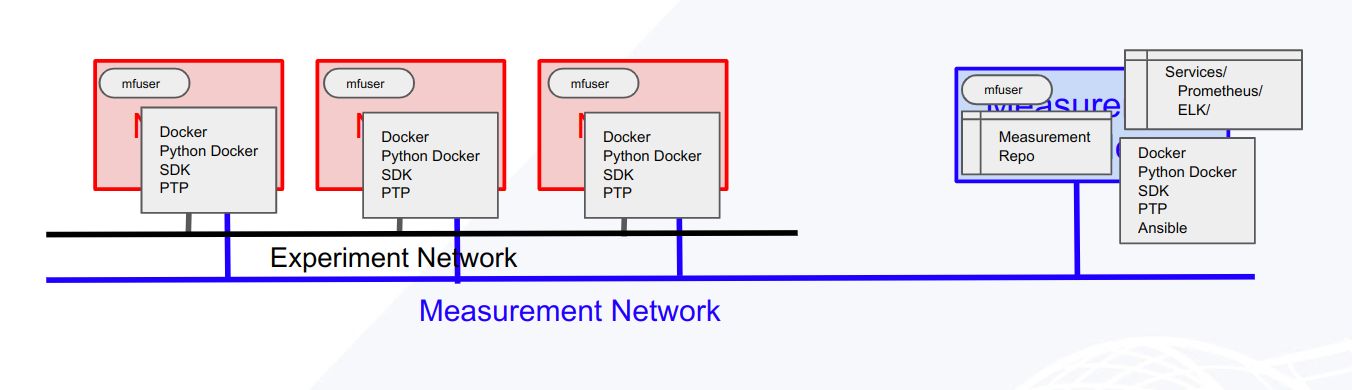

## Instrumentize the slice to start the collection of metrics.
This will install and start the basic collection software for measuring the experiment.  
Insturmentize only needs to be run once.  
Instrumentize installs Prometheus & ELK, including Grafana & Kibana, to the experiment.

In [ ]:
%%time
instrumetize_results = mf.instrumentize()

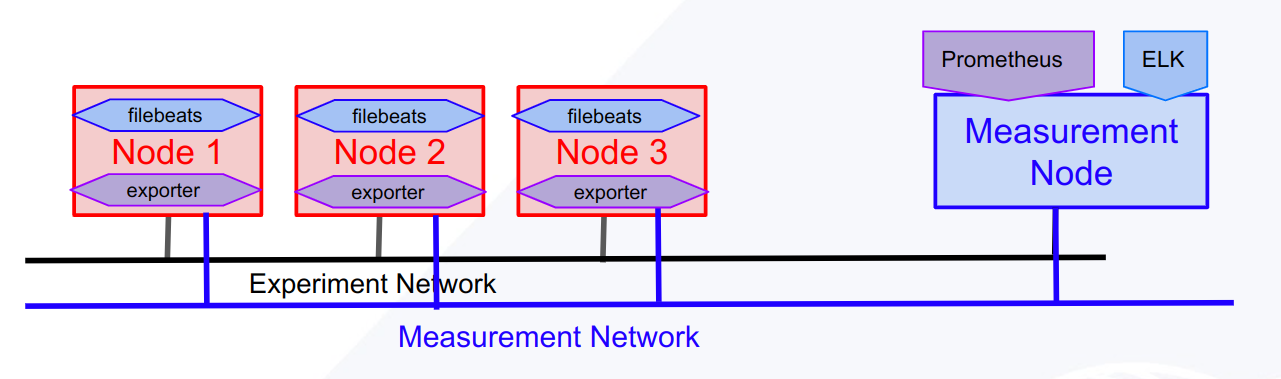

-----
# Slice Setup & Instrumentation Is Complete
The Meaurement Framework is now gathering metrics & logs.
Prometheus is gathering metrics from each node in the experiment.
Elk is gathering logs from each node in the experiment.

-----

# Prometheus
Prometheus consists of 3 basic parts:
* Prometheus client running on the Measurement Node. This client requests metrics from various exporters. 
* Exporters are servers that Prometheus contacts to get metrics. The node_exporter has been installed on each experient node.
* Grafana has been installed on the Measurement Node and provides a web GUI to visualize the gathered metrics. 

## Get Prometheus Grafana Access Info
To access the Prometheus Metrics go to the Grafana interface.  
From your local machine, you will have to tunnel through the bastion host into the measurement node.  
If you have added FABRIC_ALT_COPY_SSH_CONFIG and FABRIC_ALT_COPY_SLICE_PRIVATE_KEY_FILE to your fabric_rc file use `mf.grafana_tunnel` to get the SSH tunnel command.   

In [ ]:
# Grafana SSH Tunnel Command
print(mf.grafana_tunnel)

Otherwise you will need to create the tunnel using:
`ssh -L 10010:localhost:443 -F <fabric-ssh-config-file> -i <your portal_slice_id_rsa-file> <slice-username>@<meas_node-ip>`

Browse to [https://localhost:10010/grafana/](https://localhost:10010/grafana/)    
You will need to accept the self-signed certificate.     
The Grafana view opens to the default user. 
To login as the admin click on the door icon at the bottom left and enter u: admin p: <grafana_admin_password (see below)

The Measurement Framework works with "services". The instrumentize command installs several default services. One is the grafana_manager. The grafana_manager service lets you write python scripts to interact with the Grafana server setup on the Measurement Node.

Use the mflib.info method to retrieve information from the grafana_manager.

In [ ]:
# The grafana_manager service was created by the mf.instrumentize call.
# Get access info for Grafana by using the mflib.info call to the grafana_manager.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["admin_password"]
# Call info using service name and data dictionary.
info_results = mf.info("grafana_manager", data)
print(info_results)

# Upload Dashboard to Grafana
It is possible to upload custom dashboards to Grafana using the grafana_manager.
This example installs a very simple dashboard to see the Prometheus scrape job's status. 

Browse to https://localhost:10010/grafana/dashboards . There should be a few default dashboards including Node Exporter Full,  Network Traffic Dashboard and Pin Status.

Run the next cell, then refresh https://localhost:10010/grafana/dashboards . You should see the addition of the Up Status dashboard.

In [ ]:
data = {}
data["commands"] = []
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":["up.json"]} )
data["commands"].append({"cmd":"add_dashboards", "dashboard_filenames":["up.json"] } )

files = ["./dashboard_examples/grafana/up.json"]
mf.update("grafana_manager", data, files)

For more ways to interact with the Grafana dashboards see the MFVis jupyter notebooks.

# ELK

Elk consists of 3 basic parts:
* Elastic Search database running on the Measurement Node.
* Filebeats have been installed on the experiment nodes to push data to Elastic Search.
* Kibana has been installed on the Measurement Node and provides a web GUI to visualize the gathered metrics and logs.


## Get Kibana Access Info
To access the ELK data go to the Kibana interface.   
From your local machine, you will have to tunnel through the bastion host into the measurement node. 
If you have added FABRIC_ALT_COPY_SSH_CONFIG and FABRIC_ALT_COPY_SLICE_PRIVATE_KEY_FILE to your fabric_rc file use `mf.kibana_tunnel` to get the SSH tunnel command. 

Otherwise you will need to create the tunnel using:   
`ssh -L 10020:localhost:80 -F <fabric-ssh-config-file> -i <your portal_slice_id_rsa-file> <slice-username>@<meas_node-ip>`   


In [ ]:
# ELK SSH Tunnel Command
print(mf.kibana_tunnel)

Browse to [http://localhost:10020](http://localhost:10020) or  for dashboard listing browse to [http://localhost:10020/app/dashboards](http://localhost:10020/app/dashboards)
You will need to type in the ht_access username and password. See below.

In [ ]:
# The ELK service was created by the mf.instrumentize call.
# Get access info for Kibana by using the mflib.info call to the elk service.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["nginx_id", "nginx_password"]
# Call info using service name and data dictionary.
info_results = mf.info("elk", data)
print(info_results)

if info_results["success"]:
    print(f"user: {info_results['nginx_id']} \npass: {info_results['nginx_password']}")

In [ ]:
# A few direct links to node data 
for node in slice.get_nodes():
    if node.get_name() !=  "_meas_node":
        print(f"{node.get_name()} ELK Metric Overview")
        print(f"    http://localhost:10020/app/metrics/detail/host/{node.get_reservation_id()}-{node.get_name().lower()}")

### Upload Custom Kibana Dashboards

Upload a single dashboard.

In [ ]:
data = {}
data["commands"] = []

# Add upload_dashboards command along with dashboard filenames to upload.
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":["FABRICDashboards.ndjson"]} )

# Add add_dashboards command along with dashboard filenames to add.
data["commands"].append({"cmd":"add_dashboards", "dashboard_filenames":["FABRICDashboards.ndjson"] } )

# Add list of files to upload to the Measurement Node.
files = ["./dashboard_examples/kibana/FABRICDashboards.ndjson"]

# Call update
results = mf.update("elk", data, files)
print(results)

Upload a directory of dashboards.

In [ ]:
# Array to be filled with full paths of all dashboard files in dashboards_folder directory
dashboard_filenames = [] 
dashboards_folder = "./dashboard_examples/kibana/"

# Loop through dashboards folder
for file in os.listdir(dashboards_folder):
    # Only upload dashboard files 
    if file.endswith(".ndjson"): 
        # Add full path of dashboard to array
        dashboard_filenames.append(os.path.join(dashboards_folder, file)) 

# Build update command.
data = {}
data["commands"] = []

# Add upload_dashboards command along with dashboard filenames to upload.
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":dashboard_filenames})

# Add add_dashboards command along with dashboard filenames to add.
data["commands"].append( {"cmd":"add_dashboards", "dashboard_filenames":dashboard_filenames})

# Call update
dashboard_results = mf.update("elk", data, dashboard_filenames)
print(dashboard_results)

Testing above command format to replace below format. Both should still work.

In [ ]:
# dashboard_filenames = ["./dashboard_examples/kibana/FABRICDashboards.ndjson"] 

# data={"cmd":["upload_custom_dashboards", "add_custom_dashboards"], "dashboard_filenames":dashboard_filenames}
# dashboard_results = mf.update("elk", data, dashboard_filenames)
# print(dashboard_results)

<!-- Upload a directory of dashboards. -->

In [ ]:
# dashboard_filenames = [] #empty array to be filled with full paths
# dashboards_folder = "./dashboard_examples/kibana/"
# for file in os.listdir(dashboards_folder): #loop through dashboards folder in ~/work
#     if file.endswith(".ndjson"): #only upload dashboard files
#         dashboard_filenames.append(os.path.join(dashboards_folder, file)) #add full path of dashboard to array

# data={"cmd":["upload_custom_dashboards", "add_custom_dashboards"], "dashboard_filenames":dashboard_filenames}
# dashboard_results = mf.update("elk", data, dashboard_filenames)
# print(dashboard_results)

## Explore User Services

The Measurement Framework installs "services" on the Measurement Node that allows mflib to interact with software installed on the Measurement Node. The basic methods include `create`, `info`, `update`.
The mflib.instrumentize() method creates several services for you. These include `prometheus`, `elk`, and `grafana_manager`.
## Service Install Example
The overview service is used to get an overview of avaialable services.

In [ ]:
# Create the overview service.
mf.create("overview")

In [ ]:
# Get the default overview information.
overview_info = mf.info("overview")

In [ ]:
# Get the list of available services using the overview information.
print(overview_info["services"])

In [ ]:
# Get the READMEs for all services using the overview information.
print(overview_info["readmes"])

# Troubleshooting

### Check Service Logs
Some services keep logs for their methods. The logs can be retrieved using mflib.download_log_file.

In [ ]:
filename, filecontents = mf.download_log_file("elk", "create")
print(f"Downloaded file is at {filename}")
print(filecontents)

# Helpers for standard slice actions.
## Helper to get slice information and login commands.

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print("Node:")
        print(f"   Name              : {node.get_name()}")
        print(f"   Cores             : {node.get_cores()}")
        print(f"   RAM               : {node.get_ram()}")
        print(f"   Disk              : {node.get_disk()}")
        print(f"   Image             : {node.get_image()}")
        print(f"   Image Type        : {node.get_image_type()}")
        print(f"   Host              : {node.get_host()}")
        print(f"   Site              : {node.get_site()}")
        print(f"   Management IP     : {node.get_management_ip()}")
        print(f"   Reservation ID    : {node.get_reservation_id()}")
        print(f"   Reservation State : {node.get_reservation_state()}")
        print(f"   SSH Command       : {node.get_ssh_command()}")
        print(f"   Components        :  ")
        for component in node.get_components():
            print(f"      Name             : {component.get_name()}")
            print(f"      Details          : {component.get_details()}")
            print(f"      Disk (G)         : {component.get_disk()}")
            print(f"      Units            : {component.get_unit()}")
            print(f"      PCI Address      : {component.get_pci_addr()}")
            print(f"      Model            : {component.get_model()}")
            print(f"      Type             : {component.get_type()}") 
        print(f"   Interfaces        :  ")
        for interface in node.get_interfaces():
            print(f"       Name                : {interface.get_name()}")
            print(f"           Bandwidth           : {interface.get_bandwidth()}")
            print(f"           VLAN                : {interface.get_vlan()}")  
            print(f"           MAC                 : {interface.get_mac()}") 
            print(f"           OS iface name       : {interface.get_os_interface()}")
    for network in slice.get_l2networks():
        print("Network:")
        print(f"    Name:            {network.get_name()}")
    #print(f"Interface Map: {slice.get_interface_map()}")
except Exception as e:
    print(f"Fail: {e}")
    traceback.print_exc()

## Check/extend slice life.

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    print(f"Lease End         : {slice.get_lease_end()}")
       
except Exception as e:
    print(f"Exception: {e}")

In [ ]:
import datetime

#Extend slice
end_date = (datetime.datetime.now().astimezone() + datetime.timedelta(days=6)).strftime("%Y-%m-%d %H:%M:%S %z")

try:
    slice = fablib.get_slice(name=slice_name)
    slice.renew(end_date)
except Exception as e:
    print(f"Exception: {e}")

## Delete Slice

If you plan to go to other notebooks that use an instrumentized slice then keep the slice up. 
Otherwise you can uncomment out the next section to delete the slice.

In [ ]:
# try:
#     slice = fablib.get_slice(name=slice_name)
#     slice.delete()
# except Exception as e:
#     print(f"Fail: {e}")
#     traceback.print_exc()